## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from glob import glob

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, median_absolute_error
from sklearn.linear_model import LinearRegression

from pylab import rcParams

import warnings
warnings.filterwarnings('ignore')

## Importing Data

In [2]:
# List of filenames containing our FOREX data
forex_tables_glob = glob("../data/*.xls")

def create_forex_df(all_files_glob=glob("../data/*.xls")):

    all_files = all_files_glob

    li = []

    for filename in all_files:
        tdf = pd.read_excel(filename, skiprows=5, na_values=['CLOSED', 'closed', 'Closed', ' --']).drop([0,1,2,3,4])
        tdf = tdf.rename(columns={'Units':'Date'})

        # Convert Date to Datetime type
        tdf['Date'] = pd.to_datetime(tdf['Date'])

        # Create time series index
        tdf = tdf.set_index('Date', drop=True)
        li.append(tdf)

    df = pd.concat(li, axis=0, sort=False)
    
    return df

data = create_forex_df(forex_tables_glob).astype('float')

## Train, Validation, Test Split

Train Data : 2017 to 2018\
Validation Data : 2019\
Test Data : Jan 2020 to Feb 2020

In [3]:
# Data after 2017 (past 3 years)
data_3yrs = data['2017':]
df = data_3yrs[['USD']]

print("Total data count = ", df.shape[0])
print("Number of missing values = ", df.isnull().sum().sum())
print()

# for i in range(1, 11):
#     label = "lag_{}".format(i)
#     df[label] = df['USD'].shift(i)
    
df = df.dropna(axis=0)

train_ts = df['2017':'2018']
val_ts = df['2019']
test_ts = df['2020']

train_cv = df['2017':'2019']

print("Count of dates in training data = ", train_ts.shape[0])
print("Count of dates in validation data = ", val_ts.shape[0])
print("Count of dates in test data = ", test_ts.shape[0])

Total data count =  778
Number of missing values =  0

Count of dates in training data =  501
Count of dates in validation data =  251
Count of dates in test data =  26


# ARIMA Model

#### Inspect data

In [4]:
train_ts.describe()

,USD
count,501.000000
mean,0.757336
std,0.025461
min,0.703400
25%,0.739000
50%,0.757600
75%,0.776300
max,0.812100


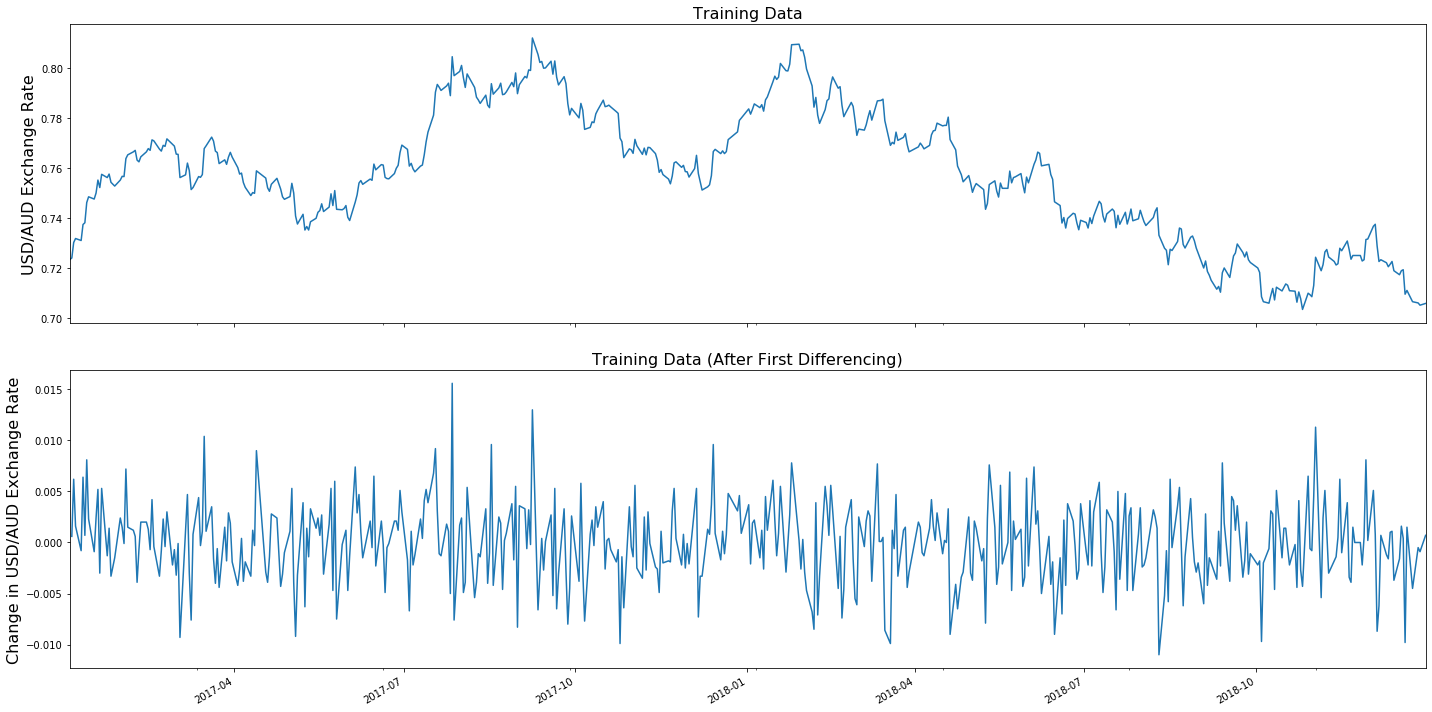

In [5]:
# Plot data
fig, ax = plt.subplots(2, sharex=True, figsize=(20,10))

# Actual Data
train_ts.plot(ax=ax[0], legend=False)
ax[0].set_title("Training Data", fontsize=16)
ax[0].set_ylabel("USD/AUD Exchange Rate", fontsize=16)

# First Differencing (to make data stationary)
train_ts.diff().plot(ax=ax[1], legend=False)
ax[1].set_title("Training Data (After First Differencing)", fontsize=16)
ax[1].set_ylabel("Change in USD/AUD Exchange Rate", fontsize=16)
ax[1].set_xlabel("")

fig.tight_layout()

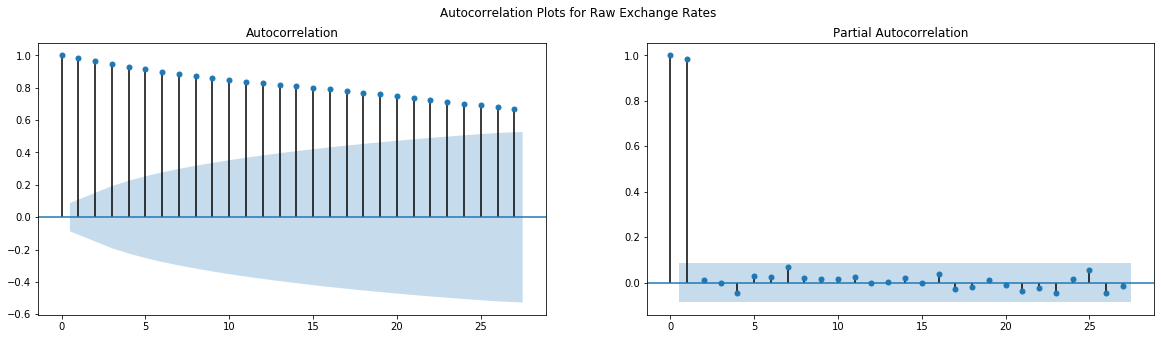

In [6]:
# ACF and PACF plots for data
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))

fig.suptitle("Autocorrelation Plots for Raw Exchange Rates")

_ = plot_acf(train_ts, ax=ax1)
_ = plot_pacf(train_ts,ax=ax2)

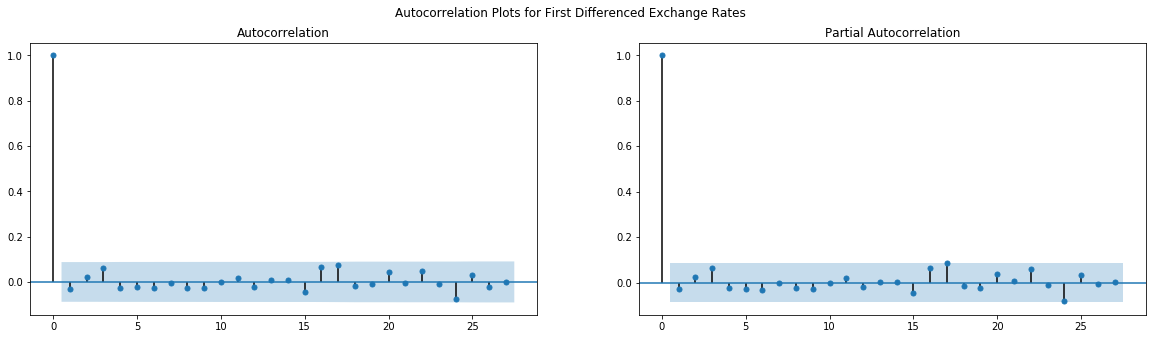

In [7]:
# ACF and PACF plots for data (after making stationary)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))

fig.suptitle("Autocorrelation Plots for First Differenced Exchange Rates")

_ = plot_acf(train_ts.diff().dropna(), ax=ax1)
_ = plot_pacf(train_ts.diff().dropna(), ax=ax2)

#### Create model

In [8]:
from statsmodels.tsa.arima_model import ARIMA

AIC = -4114.596690604656 



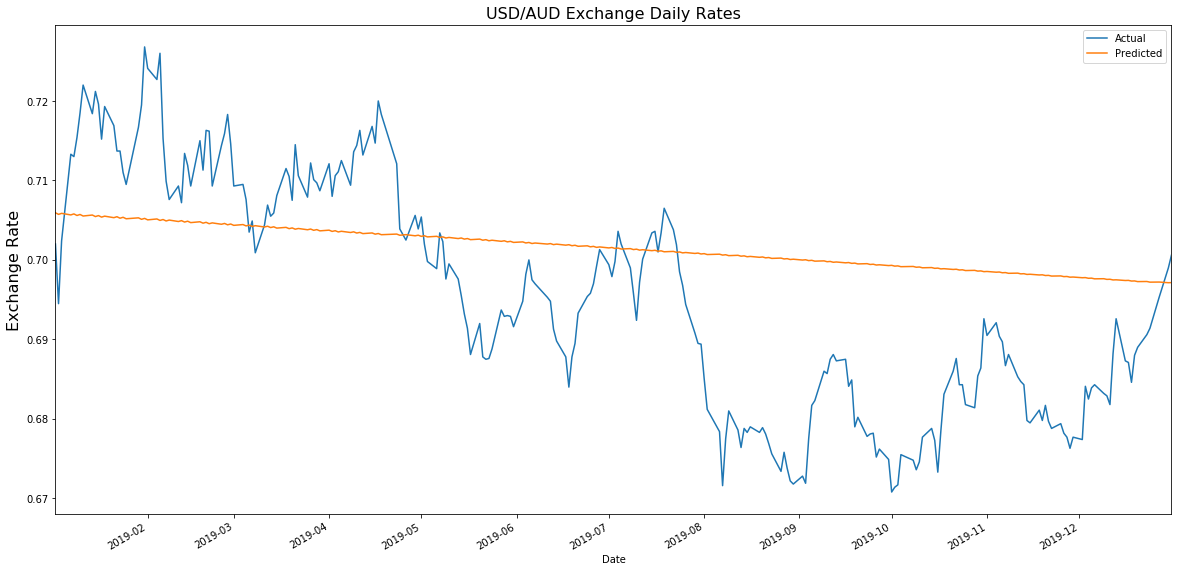

In [9]:
# ARIMA(1,1,1) Model

# Parameters = p,d,q
# p -> Auto-Regressive order
# d -> Difference order
# q -> Moving Average order

# Fit on training data
model = ARIMA(train_ts, (1,1,1))
model_fit = model.fit()

# Forecast on validation dataset
predictions = model_fit.forecast(steps=len(val_ts))

# Print AIC value for model
print("AIC =", model_fit.aic,"\n")

# Plot real and Predicted values
fig, ax = plt.subplots(figsize=(20,10))
val_ts.plot(label='Actual', ax=ax)
ax.plot(val_ts.index, predictions[0], label='Predicted')
ax.set_title("USD/AUD Exchange Daily Rates", fontsize=16)
ax.set_ylabel("Exchange Rate", fontsize=16)
ax.legend(['Actual', 'Predicted'])
fig.show()

## Identify best model parameters i.e. p, d and q. 

The least value of AIC is considered to be the best predictive forecasting model.

In [10]:
import itertools
p = d = q = range(1,5)

pdq = list(itertools.product(p,d,q))

results = pd.DataFrame(columns=['p', 'd', 'q', 'AIC', 'BIC'])

for params in pdq:
    
    try:
        model = ARIMA(train_ts, params)
        model_fit = model.fit()
        
        res = {'p':params[0],
               'd':params[1],
               'q':params[2],
               'AIC':model_fit.aic, 
               'BIC':model_fit.bic}
#         print(res)
        results = results.append(res, ignore_index=True)
    except:
        continue

# Show top 10 models
z = results.sort_values(by=['AIC', 'BIC']).head(10)
z

,p,d,q,AIC,BIC
0,1.0,1.0,1.0,-4114.596691,-4097.738258
5,2.0,1.0,1.0,-4113.204866,-4092.131826
17,4.0,1.0,1.0,-4111.953780,-4082.451523
10,3.0,1.0,1.0,-4111.428542,-4086.140893
18,4.0,1.0,2.0,-4110.094783,-4076.377919
11,3.0,1.0,2.0,-4109.876299,-4080.374043
20,4.0,1.0,4.0,-4108.766579,-4066.620498
12,3.0,1.0,3.0,-4108.607446,-4074.890581
19,4.0,1.0,3.0,-4107.753284,-4069.821811
1,1.0,2.0,1.0,-4102.022060,-4085.171635


In [11]:
# for i in z.index:
#     a = int(z.loc[i,:]['p'])
#     b = int(z.loc[i,:]['d'])
#     c = int(z.loc[i,:]['q'])
    
#     model = ARIMA(train_ts, (a,b,c))
#     model_fit = model.fit()

#     predictions = model_fit.forecast(10)[0]

#     plt.plot(val_ts.head(10).values)
#     plt.plot(predictions, color='r')
#     plt.show()
#     print(a,b,c)

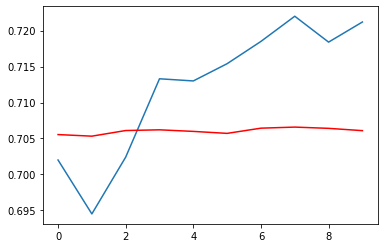

In [12]:
model = ARIMA(train_ts, (4,1,4))
model_fit = model.fit()

predictions = model_fit.forecast(10)[0]

plt.plot(val_ts.head(10).values)
plt.plot(predictions, color='r')

(0.69, 0.74)

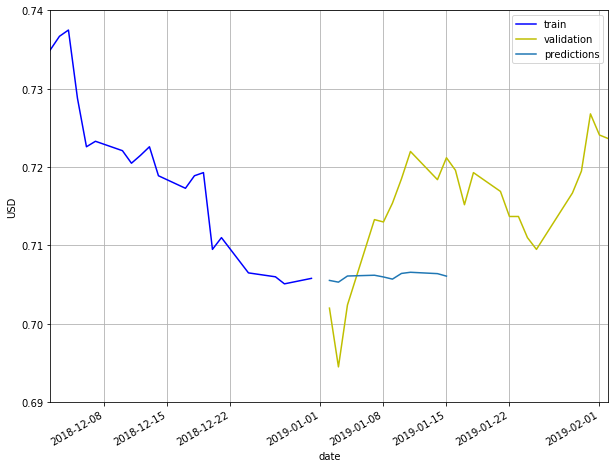

In [13]:
from datetime import date

# Plot train, validation data along with predictions for 10 days validation data
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train_ts.plot(y='USD', style='b-', grid=True)
ax = val_ts.plot(y='USD', style='y-', grid=True, ax=ax)
plt.plot(val_ts.head(10).index, predictions)
# ax = test_ts.plot(y='USD', style='g-', grid=True, ax=ax)
# ax = test.plot(y='est_N4', style='r-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2018, 12, 2), date(2019, 2, 2)])
ax.set_ylim([0.69, 0.74])

In [14]:
# Get confidence intervals for forecasts
intervals = [0.2, 0.1, 0.05, 0.01]
for a in intervals:
    forecast, stderr, conf = model_fit.forecast(alpha=a)
    print('%.1f%% Prediction Interval: %.3f between %.3f and %.3f' % ((1-a)*100, forecast, conf[0][0], conf[0][1]))

80.0% Prediction Interval: 0.706 between 0.701 and 0.711
90.0% Prediction Interval: 0.706 between 0.699 and 0.712
95.0% Prediction Interval: 0.706 between 0.698 and 0.713
99.0% Prediction Interval: 0.706 between 0.696 and 0.716


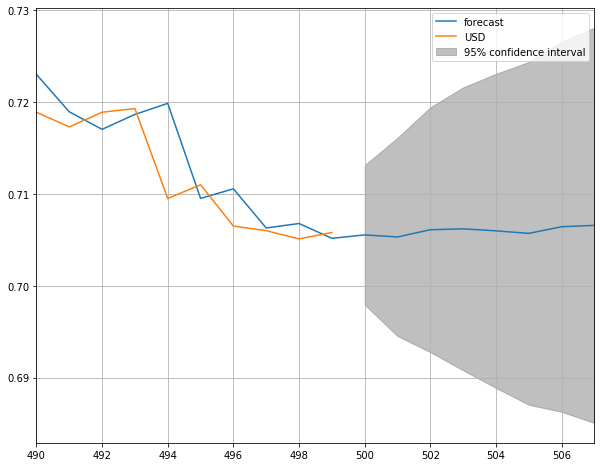

In [15]:
_ = model_fit.plot_predict(len(train_ts)-10, len(train_ts)+7)
plt.grid()

# Profit

#### Some Functions

In [139]:

def buy_usd(aud_amt, exchange_rate):
    return aud_amt * exchange_rate

def buy_aud(usd_amt, exchange_rate):
    return usd_amt / exchange_rate

def buy_sell_plot(y, y_pred):
    buy_sell_df = pd.DataFrame(zip(y, y_pred), index = y.index, columns=['USD', 'Predictions'])
    
    buy_sell_df['predicted_change'] = buy_sell_df['Predictions'].diff().shift(-1)
    buy_sell_df['buy'] = buy_sell_df['predicted_change'].apply(lambda x: 1 if x >0 else (2 if x==0 else 0))

    buy_sell_df['USD'].plot()
    scatter = plt.scatter(buy_sell_df.index, buy_sell_df['USD'], c=buy_sell_df.buy)
    legend = plt.legend(*scatter.legend_elements())
    plt.title("Strategy on Predictions (Sell, Buy or Hold)")
    plt.show()
    
    return buy_sell_df

def backtest(y, y_pred, initial_investment=1000, trade_amount=100):

    bsdf = pd.DataFrame(zip(y, y_pred), index = y.index, columns=['USD', 'Predictions'])
    
    bsdf['predicted_change'] = bsdf['Predictions'].diff().shift(-1)
    bsdf['buy'] = bsdf['predicted_change'].apply(lambda x: 1 if x >0 else (2 if x==0 else 0))

    logs = []
    profits = []

    strategy = bsdf.buy
    wallet = initial_investment
    
    for i in range(len(strategy)-1):
        rate_today = y[i]
        rate_future = y[i+1]
        buy = strategy[i]
#         print(buy)

        trade_money = trade_amount * rate_today
        wallet -= trade_amount

        if buy == 0:
            profit = trade_money - trade_amount * rate_future
        elif buy == 1:
            profit = trade_amount * rate_future - trade_money
        elif buy == 2:
            profit = 0
       
        
        if profit >= 0:
            wallet += trade_amount + profit
        else:
            wallet += trade_amount + profit

        logs.append(wallet)

    net_profit = wallet - initial_investment
    
#     plt.plot(bsdf.index[1:], logs)
#     plt.xticks(rotation=90)
#     plt.legend(["Net Profit = %.2f"%(net_profit)])
#     plt.title("Investment Growth over time")
#     plt.show()

    return net_profit, logs

def random_simulation(simulation_rate, ar_profit_on_same_data, limit=0.3):
    initial_investment = 1000
    trade_amount = 100

    profits = []

    for it in range(5000):

        random_strategy = np.random.randint(2, size=len(simulation_rate))

        wallet = initial_investment
        logs = []

        for i in range(len(random_strategy)-1):
            rate_today = simulation_rate[i]
            rate_future = simulation_rate[i+1]
            buy = random_strategy[i]

            trade_money = trade_amount * rate_today
            wallet -= trade_amount

            if buy == 0:
                profit = trade_money - trade_amount * rate_future
            elif buy == 1:
                profit = trade_amount * rate_future - trade_money
            elif buy == 2:
                profit = 0


            if profit >= 0:
                wallet += trade_amount + profit
            else:
                wallet += trade_amount + profit

            logs.append(wallet)

        net_profit = wallet - initial_investment

        profits.append(net_profit)
        
    legend_label = "Profit = %0.2f"%ar_profit_on_same_data

    sns.distplot(profits)
    plt.vlines(ar_profit_on_same_data, 0, limit, label='Profit with ARIMA Forecast')
    max_possible_profit, _ = backtest(y, y)
    plt.vlines(max_possible_profit, 0, limit)
    plt.legend([legend_label])
    plt.show()
    
def predict(train_data, n_steps):
    model = ARIMA(train_data, (4,1,4))
    model_fit = model.fit()

    predictions = model_fit.forecast(n_steps)[0]

    return predictions

def profit_dataframe(train_ts=train_ts, val_ts = val_ts.head()):
    import itertools

    profit_on_validation5 = pd.DataFrame(columns=['p','d','q','Profit'])

    p = d = q = range(1,5)

    pdq = list(itertools.product(p,d,q))

    for params in pdq:

        try:

            model = ARIMA(train_ts, params)
            model_fit = model.fit()

            y = val_ts['USD']
            
            y_pred = model_fit.forecast(len(val_ts))[0]

            model_net_profit, investment_growth = backtest(y, y_pred)

            profit_on_validation5 = profit_on_validation5.append({'p': params[0],
                                                                  'd': params[1], 
                                                                  'q': params[2], 
                                                                  'Profit': model_net_profit}, ignore_index=True)

        except:
            continue

    profit_on_validation5 = profit_on_validation5.sort_values(by='Profit', ascending=False)  
    
    return profit_on_validation5.head(15)

In [39]:
model_fit.forecast(10)

(array([0.70029043, 0.69980088, 0.69920127, 0.69880301, 0.69862393,
        0.69842622, 0.69825245, 0.69818808, 0.69813155, 0.69805193]),
 array([0.0031516 , 0.00445465, 0.00546293, 0.00630115, 0.006904  ,
        0.00741302, 0.00790746, 0.00834288, 0.00872955, 0.00910931]),
 array([[0.69411341, 0.70646746],
        [0.69106994, 0.70853183],
        [0.68849412, 0.70990842],
        [0.68645299, 0.71115304],
        [0.68509234, 0.71215552],
        [0.68389696, 0.71295548],
        [0.68275412, 0.71375079],
        [0.68183635, 0.71453982],
        [0.68102196, 0.71524115],
        [0.68019802, 0.71590585]]))

In [40]:
def profit_dataframe(train_ts=train_ts, val_ts = val_ts):
    import itertools

    profit_on_validation5 = pd.DataFrame(columns=['p','d','q','Profit'])

    p = d = q = range(1,5)

    pdq = list(itertools.product(p,d,q))

    for params in pdq:

        try:

            model = ARIMA(train_ts, params)
            model_fit = model.fit()

            y = val_ts['USD']
            y_pred = model_fit.forecast(len(val_ts))[0]

            model_net_profit, investment_growth = backtest(y, y_pred)
            profit_on_validation5 = profit_on_validation5.append({'p': params[0],
                                                                  'd': params[1], 
                                                                  'q': params[2], 
                                                                  'Profit': model_net_profit}, ignore_index=True)

        except:
            continue

    profit_on_validation5 = profit_on_validation5.sort_values(by='Profit', ascending=False)  
    
    return profit_on_validation5

profit_dataframe()

,p,d,q,Profit
20,4.0,1.0,4.0,4.20
17,4.0,1.0,1.0,3.44
18,4.0,1.0,2.0,2.82
0,1.0,1.0,1.0,1.10
10,3.0,1.0,1.0,1.10
11,3.0,1.0,2.0,1.10
13,3.0,2.0,1.0,0.14
23,4.0,2.0,3.0,0.14
22,4.0,2.0,2.0,0.14
21,4.0,2.0,1.0,0.14


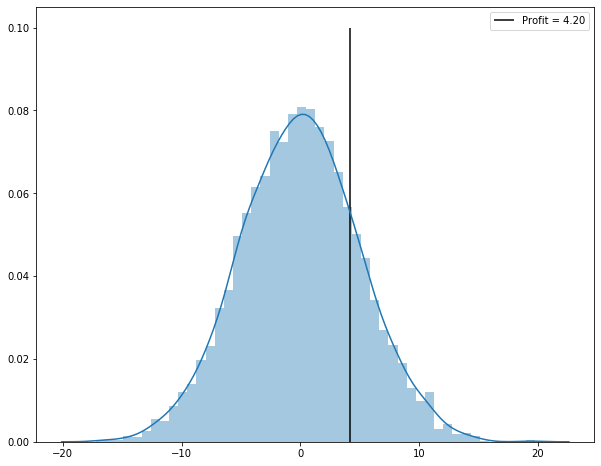

In [41]:
random_simulation(val_ts.values, 4.2, 0.1)

In [42]:
model = ARIMA(train_ts, (4,1,4))
model_fit = model.fit()

predictions = model_fit.forecast(len(val_ts.head()))[0]

# plt.plot(test_ts.values)
# plt.plot(predictions, color='r')

import statsmodels.api as sm

y_pred = predictions
y = val_ts.head()['USD']

residuals = y - y_pred

# test_stat, p_val = sm.stats.acorr_ljungbox(residuals)
# print("P-Value =", p_val)
# print("Ljung-Box Statistic =", test_stat)


    
_ = buy_sell_plot(y, y_pred)



model_net_profit, investment_growth = backtest(y, y_pred)


    



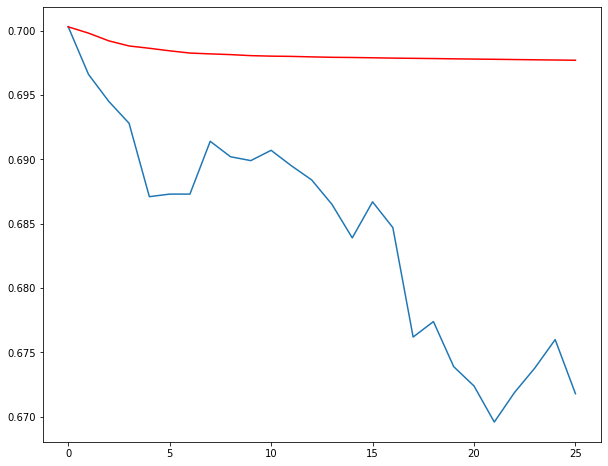

In [43]:
model = ARIMA(val_ts, (4,1,3))
model_fit = model.fit()

predictions = model_fit.forecast(len(test_ts))[0]

plt.plot(test_ts.values)
plt.plot(predictions, color='r')

In [44]:
import statsmodels.api as sm

y_pred = predictions
y = test_ts['USD']

residuals = y - y_pred

test_stat, p_val = sm.stats.acorr_ljungbox(residuals, lags=[20])
print("P-Value =", p_val)
print("Ljung-Box Statistic =", test_stat)

P-Value = [3.49332323e-18]
Ljung-Box Statistic = [130.25373027]


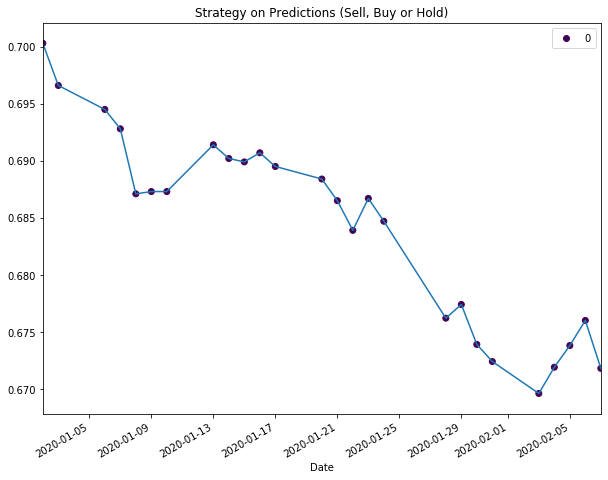

In [45]:
def buy_usd(aud_amt, exchange_rate):
    return aud_amt * exchange_rate

def buy_aud(usd_amt, exchange_rate):
    return usd_amt / exchange_rate

def buy_sell_plot(y, y_pred):
    buy_sell_df = pd.DataFrame(zip(y, y_pred), index = y.index, columns=['USD', 'Predictions'])
    
    buy_sell_df['predicted_change'] = buy_sell_df['Predictions'].diff().shift(-1)
    buy_sell_df['buy'] = buy_sell_df['predicted_change'].apply(lambda x: 1 if x >0 else (2 if x==0 else 0))

    buy_sell_df['USD'].plot()
    scatter = plt.scatter(buy_sell_df.index, buy_sell_df['USD'], c=buy_sell_df.buy)
    legend = plt.legend(*scatter.legend_elements())
    plt.title("Strategy on Predictions (Sell, Buy or Hold)")
    
    return buy_sell_df
    
_ = buy_sell_plot(y, y_pred)

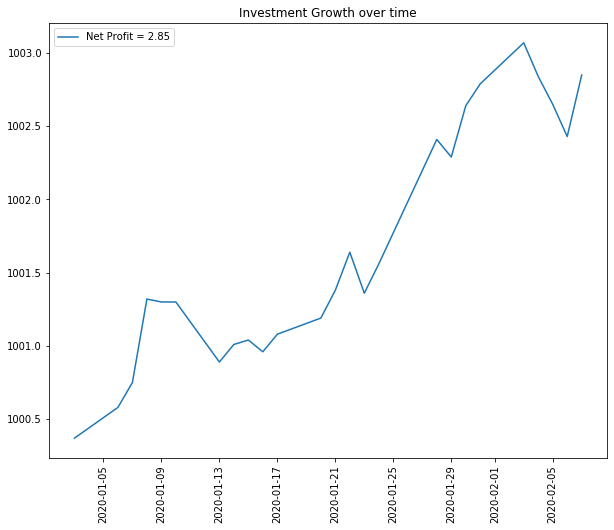

In [46]:
def backtest(y, y_pred, initial_investment=1000, trade_amount=100):

    bsdf = pd.DataFrame(zip(y, y_pred), index = y.index, columns=['USD', 'Predictions'])
    
    bsdf['predicted_change'] = bsdf['Predictions'].diff().shift(-1)
    bsdf['buy'] = bsdf['predicted_change'].apply(lambda x: 1 if x >0 else (2 if x==0 else 0))

    logs = []
    profits = []

    strategy = bsdf.buy
    wallet = initial_investment

    for i in range(len(strategy)-1):
        rate_today = y[i]
        rate_future = y[i+1]
        buy = strategy[i]
#         print(buy)

        trade_money = trade_amount * rate_today
        wallet -= trade_amount

        if buy == 0:
            profit = trade_money - trade_amount * rate_future
        elif buy == 1:
            profit = trade_amount * rate_future - trade_money
        elif buy == 2:
            profit = 0
       
        
        if profit >= 0:
            wallet += trade_amount + profit
        else:
            wallet += trade_amount + profit

        logs.append(wallet)

    net_profit = wallet - initial_investment
    
    plt.plot(bsdf.index[1:], logs)
    plt.xticks(rotation=90)
    plt.legend(["Net Profit = %.2f"%(net_profit)])
    plt.title("Investment Growth over time")
    plt.show()

    return net_profit, logs

model_net_profit, investment_growth = backtest(y, y_pred)

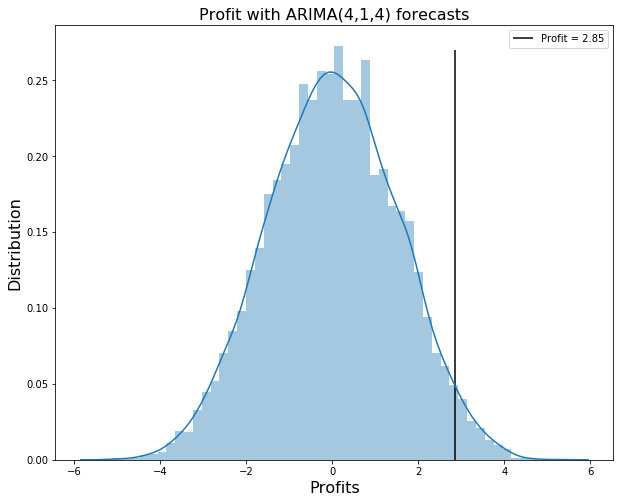

In [47]:
initial_investment = 1000
trade_amount = 100

profits = []

for it in range(10000):

    random_strategy = np.random.randint(2, size=len(y))

    wallet = initial_investment
    logs = []

    for i in range(len(random_strategy)-1):
        rate_today = y[i]
        rate_future = y[i+1]
        buy = random_strategy[i]
    #         print(buy)

        trade_money = trade_amount * rate_today
        wallet -= trade_amount

        if buy == 0:
            profit = trade_money - trade_amount * rate_future
        elif buy == 1:
            profit = trade_amount * rate_future - trade_money
        elif buy == 2:
            profit = 0


        if profit >= 0:
            wallet += trade_amount + profit
        else:
            wallet += trade_amount + profit

        logs.append(wallet)

    net_profit = wallet - initial_investment
    
    profits.append(net_profit)
    
profit_label = "Profit = %0.2f"%model_net_profit

sns.distplot(profits)
plt.xlabel("Profits", fontsize=16)
plt.ylabel("Distribution", fontsize=16)
plt.title("Profit with ARIMA(4,1,4) forecasts", fontsize=16)
plt.vlines(model_net_profit, 0, 0.27, label='Profit with ARIMA Forecast')
plt.legend([profit_label])
plt.show()

# Maximum possible profit on validation data (if all predictions are correct)

In [48]:
val_ts

,USD
Date,
2019-01-02,0.7020
2019-01-03,0.6945
2019-01-04,0.7024
2019-01-07,0.7133
2019-01-08,0.7130
...,...
2019-12-23,0.6906
2019-12-24,0.6914
2019-12-27,0.6953


In [49]:
df_best = val_ts.copy()
df_best['buy'] = df_best['USD'].diff()

df_best = df_best.dropna()
df_best['buy'] = df_best['buy'].apply(lambda x: 0 if x < 0 else (1 if x > 0 else 2))
df_best

,USD,buy
Date,,
2019-01-03,0.6945,0
2019-01-04,0.7024,1
2019-01-07,0.7133,1
2019-01-08,0.7130,0
2019-01-09,0.7154,1
...,...,...
2019-12-23,0.6906,1
2019-12-24,0.6914,1
2019-12-27,0.6953,1


Text(0.5, 1.0, 'Strategy on Predictions (Sell, Buy or Hold)')

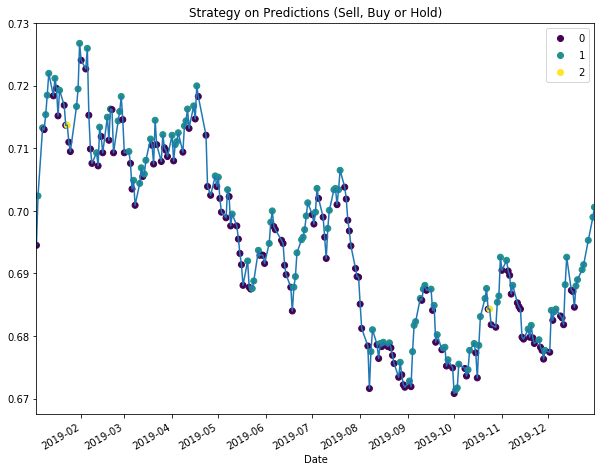

In [50]:
df_best['USD'].plot()
scatter = plt.scatter(x=df_best.index, y=df_best['USD'], c=df_best.buy)
legend = plt.legend(*scatter.legend_elements())
plt.title("Strategy on Predictions (Sell, Buy or Hold)")


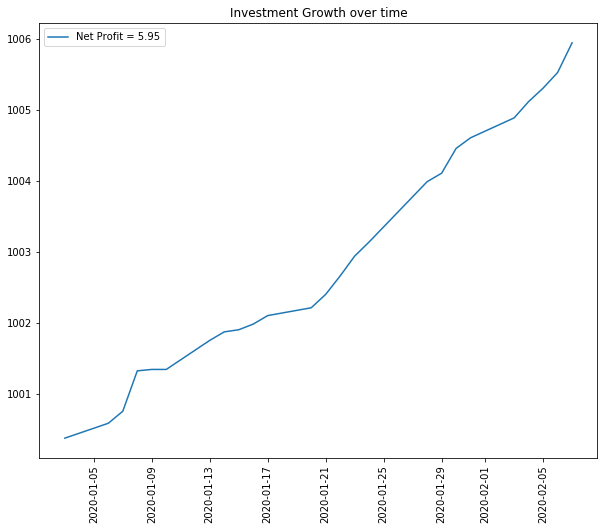

In [51]:
max_val_profit, val_growth = backtest(test_ts['USD'], test_ts['USD'])

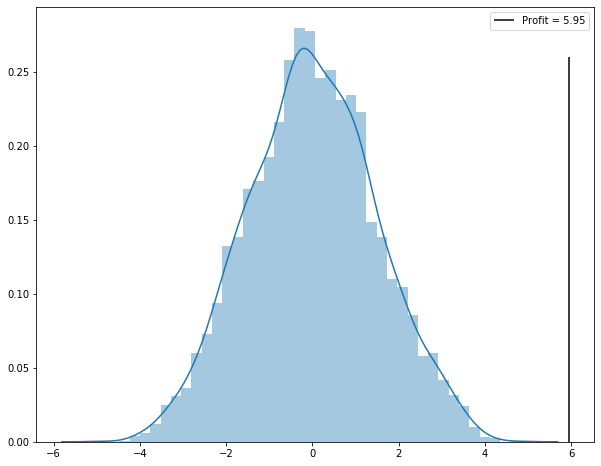

In [52]:
_ = random_simulation(test_ts.values, max_val_profit, 0.26)

In [53]:
def random_simulation(simulation_rate, ar_profit_on_same_data, limit=0.3):
    initial_investment = 1000
    trade_amount = 100

    profits = []

    for it in range(5000):

        random_strategy = np.random.randint(2, size=len(simulation_rate))

        wallet = initial_investment
        logs = []

        for i in range(len(random_strategy)-1):
            rate_today = simulation_rate[i]
            rate_future = simulation_rate[i+1]
            buy = random_strategy[i]

            trade_money = trade_amount * rate_today
            wallet -= trade_amount

            if buy == 0:
                profit = trade_money - trade_amount * rate_future
            elif buy == 1:
                profit = trade_amount * rate_future - trade_money
            elif buy == 2:
                profit = 0


            if profit >= 0:
                wallet += trade_amount + profit
            else:
                wallet += trade_amount + profit

            logs.append(wallet)

        net_profit = wallet - initial_investment

        profits.append(net_profit)
        
    legend_label = "Profit = %0.2f"%ar_profit_on_same_data
    
    from scipy.stats import norm
#     ax = sns.distplot(x, fit=norm, kde=False)
    sns.distplot(profits)
    plt.xlabel("Profit", fontsize=16)
    plt.ylabel("Distribution", fontsize=16)
    plt.title("Best Performing Forecast", fontsize=16)
    plt.vlines(ar_profit_on_same_data, 0, limit, label='Profit with ARIMA Forecast')
    plt.legend(["Profit = %0.2f"%ar_profit_on_same_data])
    plt.show()

    return profits

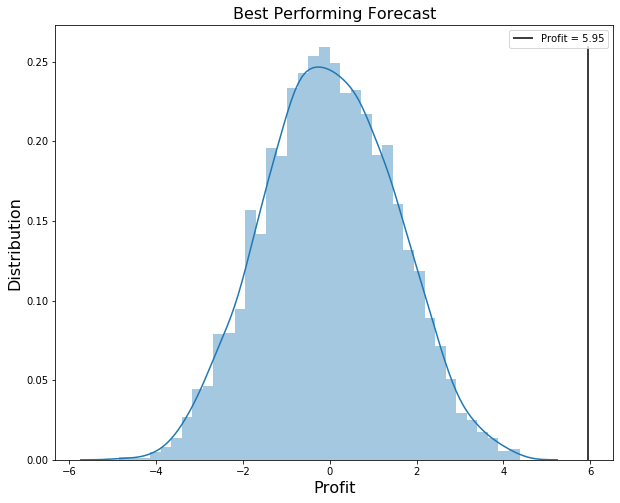

26

In [54]:
p= random_simulation(test_ts.values, max_val_profit, 0.26)
len(test_ts)

In [55]:
np.array(p)

-0.0189 and 0.0653
np.array(p).std()

1.501552985683786

In [148]:
def backtest(y, y_pred, invert=False, initial_investment=1000, trade_amount=100):

    bsdf = pd.DataFrame(zip(y, y_pred), index = y.index, columns=['USD', 'Predictions'])
    
    bsdf['predicted_change'] = bsdf['Predictions'].diff().shift(-1)
    if invert == False:
        bsdf['buy'] = bsdf['predicted_change'].apply(lambda x: 1 if x >0 else (2 if x==0 else 0))
    else:
        bsdf['buy'] = bsdf['predicted_change'].apply(lambda x: 0 if x >0 else (2 if x==0 else 1))
        
    logs = []
    profits = []

    strategy = bsdf.buy
    wallet = initial_investment
    
    for i in range(len(strategy)-1):
        rate_today = y[i]
        rate_future = y[i+1]
        buy = strategy[i]
#         print(buy)

        trade_money = trade_amount * rate_today
        wallet -= trade_amount

        if buy == 0:
            profit = trade_money - trade_amount * rate_future
        elif buy == 1:
            profit = trade_amount * rate_future - trade_money
        elif buy == 2:
            profit = 0
       
        
        if profit >= 0:
            wallet += trade_amount + profit
        else:
            wallet += trade_amount + profit

        logs.append(wallet)

    net_profit = wallet - initial_investment
    
#     plt.plot(bsdf.index[1:], logs)
#     plt.xticks(rotation=90)
#     plt.legend(["Net Profit = %.2f"%(net_profit)])
#     plt.title("Investment Growth over time")
#     plt.show()

    return net_profit, logs
backtest(test_ts['USD'], test_ts['USD'])

(5.949999999999818,
 [1000.37,
  1000.58,
  1000.75,
  1001.3199999999999,
  1001.3399999999999,
  1001.3399999999999,
  1001.7499999999999,
  1001.8699999999999,
  1001.8999999999999,
  1001.9799999999999,
  1002.0999999999999,
  1002.2099999999999,
  1002.3999999999999,
  1002.6599999999999,
  1002.9399999999998,
  1003.1399999999999,
  1003.9899999999999,
  1004.1099999999999,
  1004.4599999999999,
  1004.6099999999999,
  1004.8899999999999,
  1005.1199999999999,
  1005.3099999999998,
  1005.5299999999999,
  1005.9499999999998])

## ARIMA Model on different time slices

In [63]:
ts = data_3yrs['USD']
ts.isnull().sum()

0

In [64]:
len(ts)

778

In [208]:
len(result.trend.fillna(np.mean(result.trend)))
len(train_val)
# result.trend

193

In [219]:
for params in pdq:
    
    result = seasonal_decompose(train_val, model='additive', freq=14)
    model = ARIMA(train_val[1:], order=params, exog=[result.trend.fillna(np.mean(result.trend))])
    model_fit = model.fit()

    aics.append(model_fit.aic)

    val_predictions = model_fit.forecast(val_size)[0]
    print(val_predictions)
    profit = backtest(y, val_predictions)[0]
    profits.append(profit)
#         predictions = model_fit.forecast(h)[0]
    print(params, backtest(y, val_predictions)[0])

ValueError: endog and exog matrices are different sizes

In [168]:
!pip install chart-studio

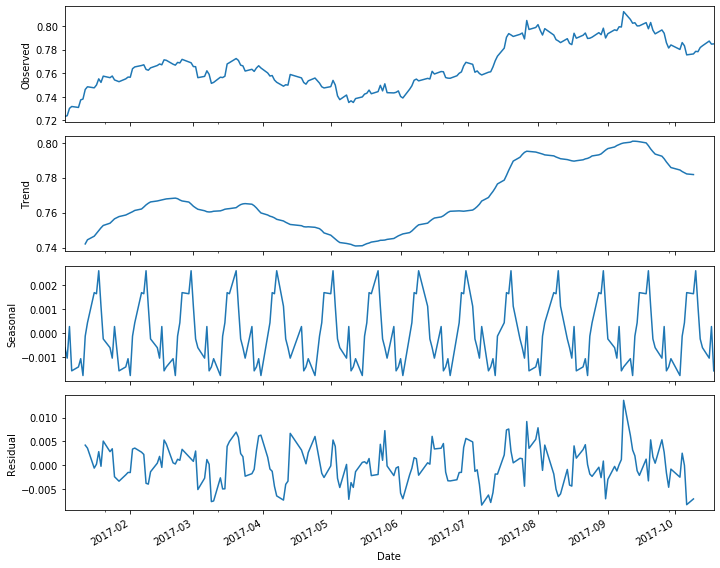

In [197]:
from statsmodels.tsa.seasonal import seasonal_decompose
from chart_studio.plotly import plot_mpl

# Start and end indices for training data
start = 0
end = start + 200

val_size = 7

# Split into data and labels 
train_val = ts[start : end-val_size]
val = ts[end-val_size : end]

train = ts[start : end]
y = ts[end : end+h]

result = seasonal_decompose(train, model='additive', freq=14)
fig = result.plot()
# plot_mpl(fig)
# result.trend

In [177]:
train.index = pd.to_datetime(train.index)

Max profit on validation data = 4.230000000000246
(4, 1, 2) 0.41000000000008185
(4, 1, 3) -1.4700000000000273
(4, 2, 2) -0.41000000000008185
(4, 2, 3) -0.41000000000008185
(4, 2, 4) -0.41000000000008185
0
(4, 1, 2)


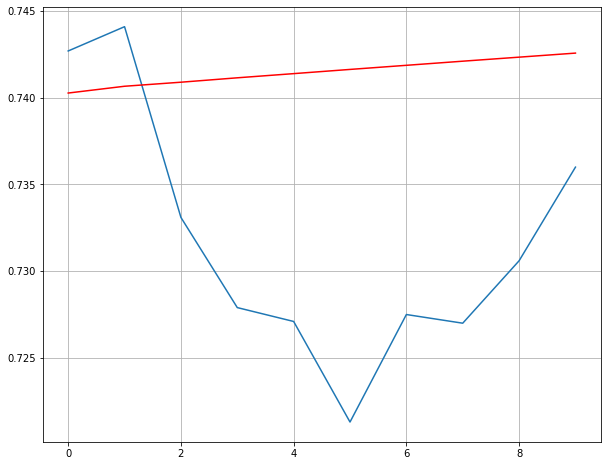

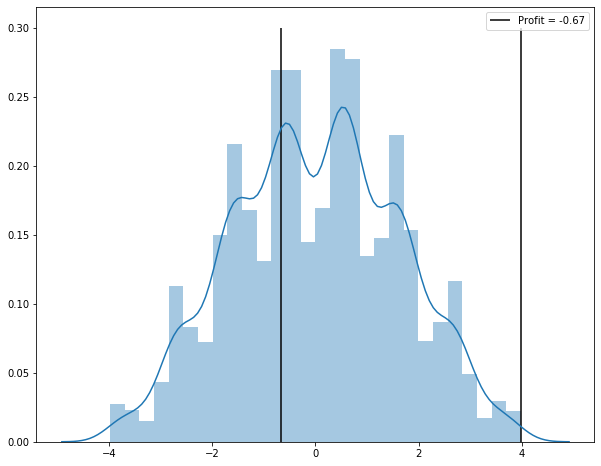

Max profit on validation data = 3.78999999999985
(4, 1, 2) -1.4099999999997408
(4, 1, 3) 0.8499999999997954
(4, 2, 2) 0.47000000000014097
(4, 2, 3) 0.8700000000000045
(4, 2, 4) 0.47000000000014097
20
(4, 2, 3)


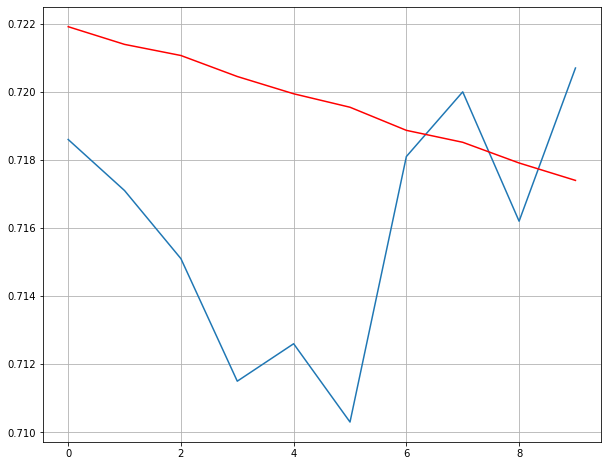

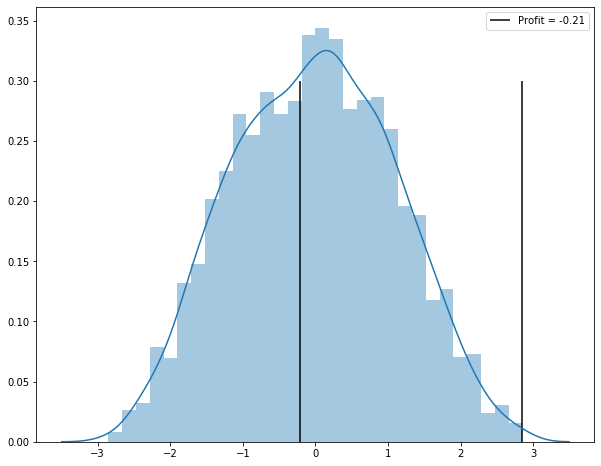

Max profit on validation data = 3.4500000000000455
(4, 1, 2) 0.849999999999909
(4, 1, 3) 0.19000000000005457
(4, 1, 4) 0.849999999999909
(4, 2, 2) -0.010000000000218279
(4, 2, 3) -0.010000000000218279
(4, 2, 4) -0.010000000000218279
40
(4, 1, 2)


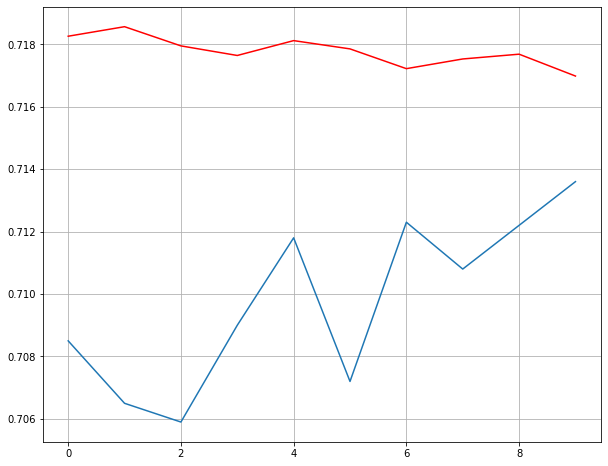

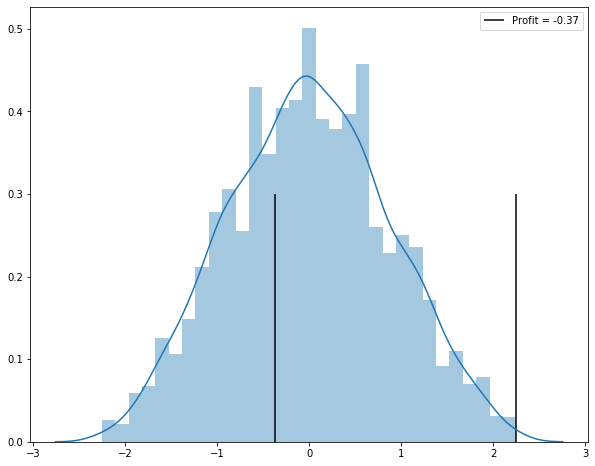

Max profit on validation data = 3.059999999999718
(4, 1, 2) 0.6599999999998545
(4, 1, 3) 0.5399999999999636
(4, 1, 4) 0.7799999999999727
(4, 2, 2) 0.37999999999988177
(4, 2, 3) 0.37999999999988177
(4, 2, 4) 0.37999999999988177
60
(4, 1, 4)


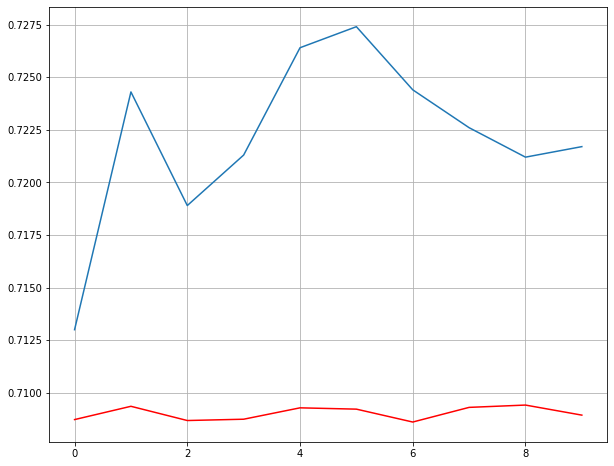

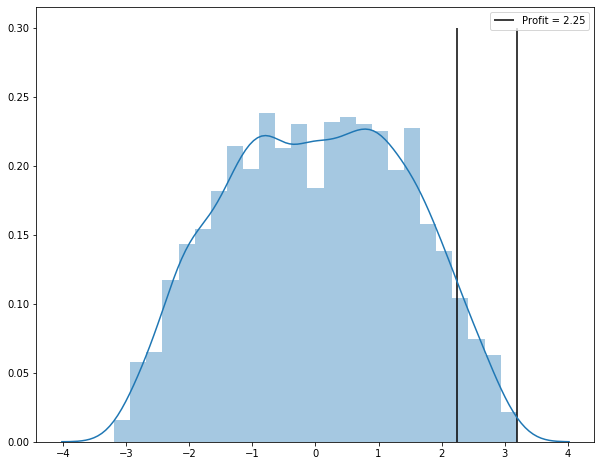

Max profit on validation data = 2.6299999999998818
(4, 1, 2) 1.4900000000002365
(4, 1, 3) -0.6299999999998818
(4, 1, 4) -0.4299999999998363
(4, 2, 2) -0.16999999999984539
(4, 2, 3) -0.11000000000012733
(4, 2, 4) 0.11000000000012733
80
(4, 1, 2)


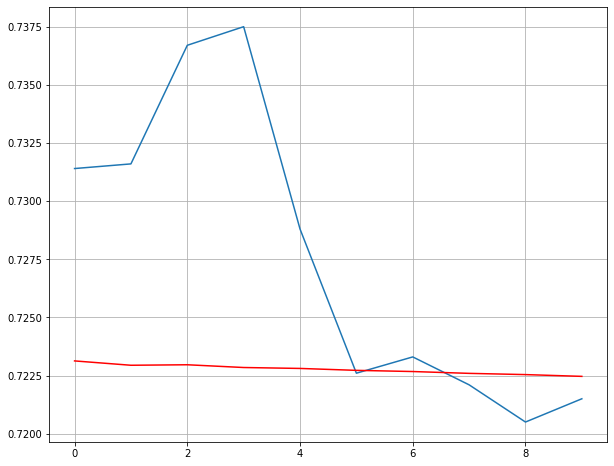

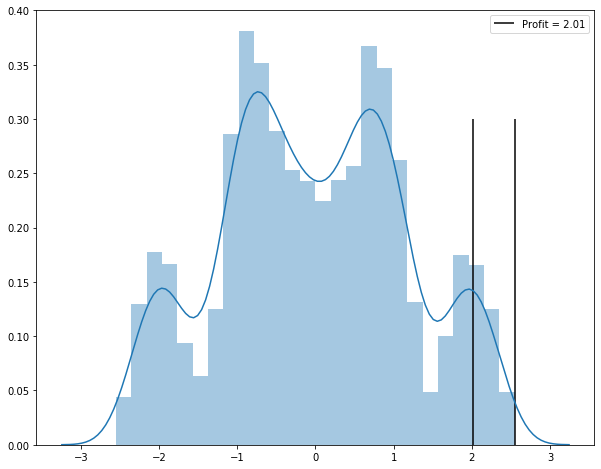

Max profit on validation data = 2.939999999999941
(4, 1, 2) -1.1399999999999864
(4, 1, 3) -1.1399999999999864
(4, 2, 2) 1.82000000000005
(4, 2, 3) 1.82000000000005
(4, 2, 4) 2.0200000000000955
100
(4, 2, 4)


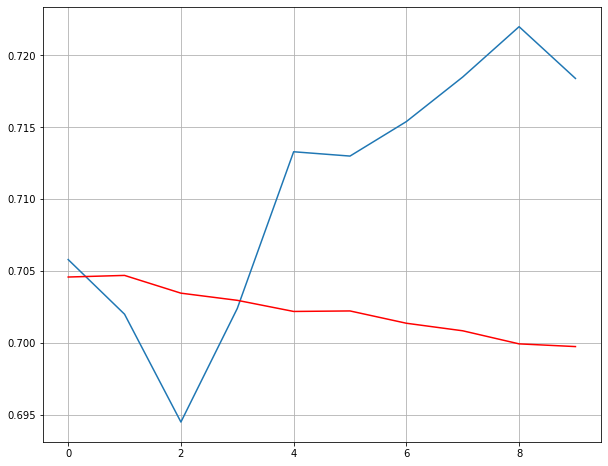

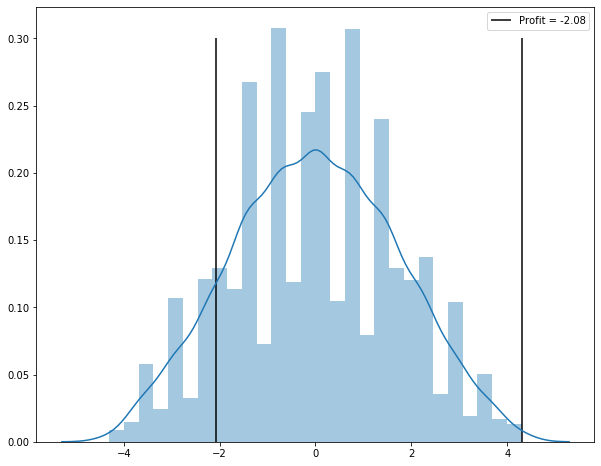

Max profit on validation data = 4.009999999999877
(4, 1, 2) 1.5300000000000864
(4, 1, 3) 1.5300000000000864
(4, 2, 2) 0.4899999999998954
(4, 2, 3) -0.8500000000000227
120
(4, 1, 2)


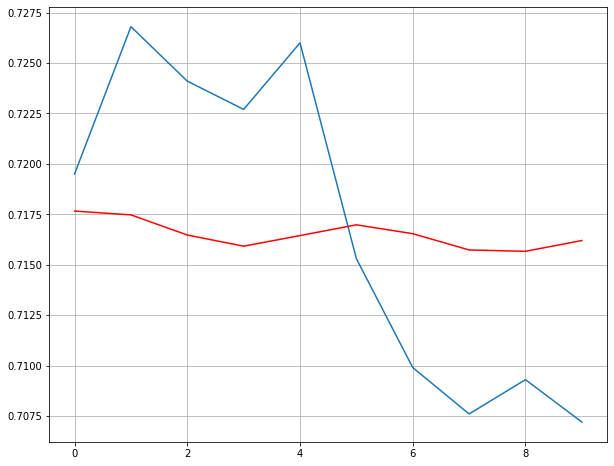

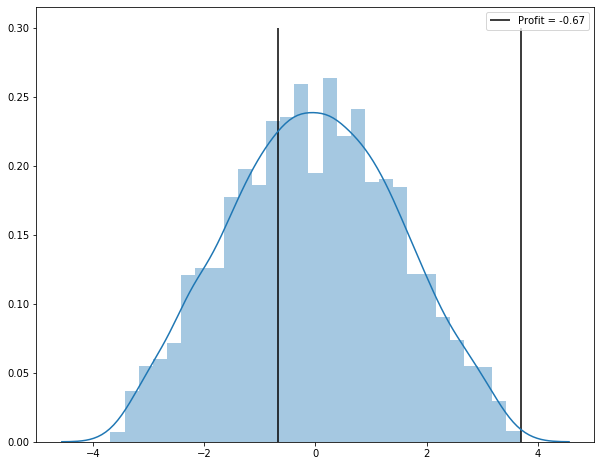

Max profit on validation data = 4.439999999999941
(4, 1, 2) -1.5400000000000773
(4, 1, 3) 0.2599999999998772
(4, 1, 4) -0.44000000000016826
(4, 2, 2) -1.0200000000000955
(4, 2, 3) -1.0000000000001137
140
(4, 1, 3)


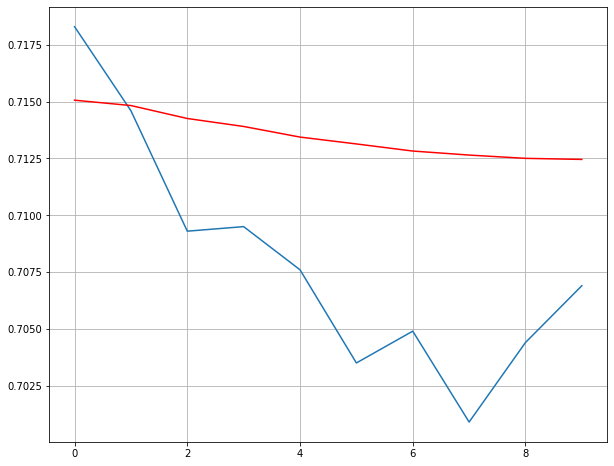

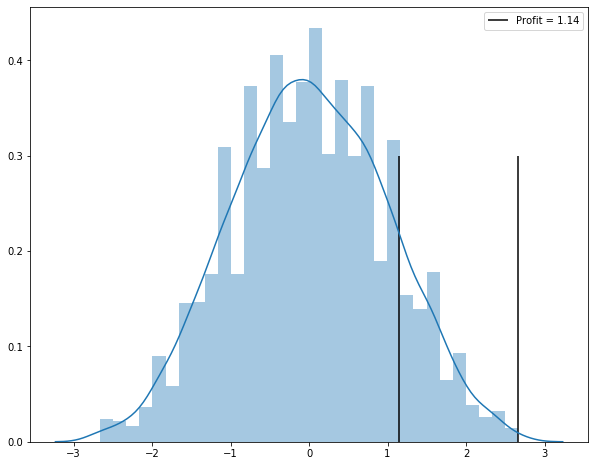

Max profit on validation data = 3.9300000000000637
(4, 1, 2) -0.7300000000002456
(4, 1, 3) -0.7300000000002456
(4, 2, 2) -0.7300000000002456
(4, 2, 3) 0.6499999999998636
160
(4, 2, 3)


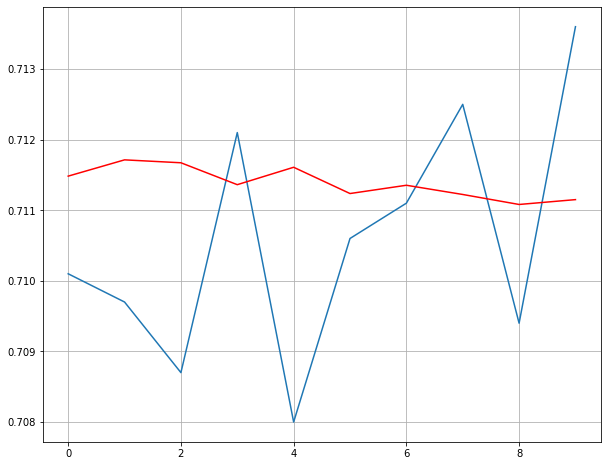

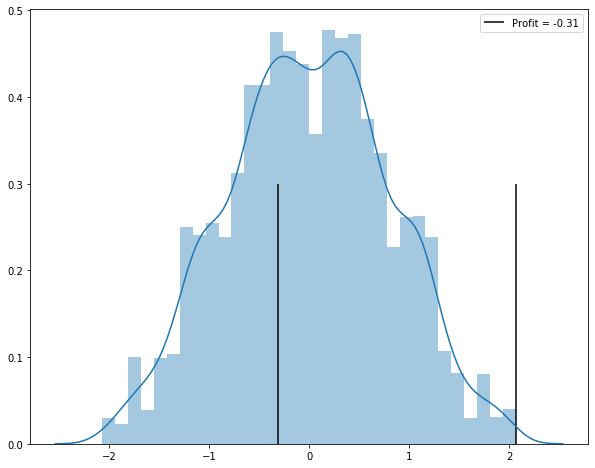

Max profit on validation data = 4.300000000000068
(4, 1, 2) 0.8600000000000136
(4, 1, 3) 0.8600000000000136
(4, 2, 2) -2.3600000000000136
(4, 2, 3) 2.2399999999998954
180
(4, 2, 3)


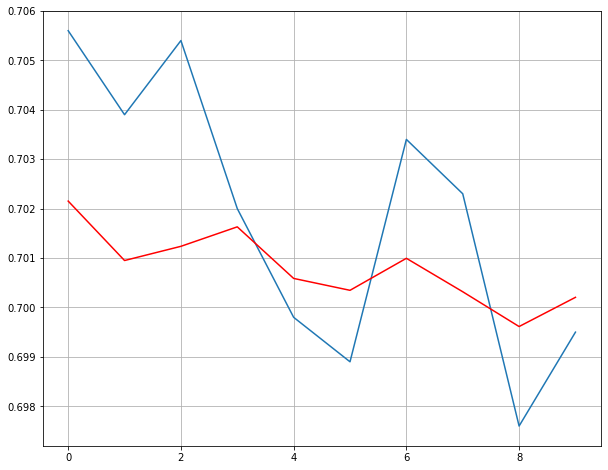

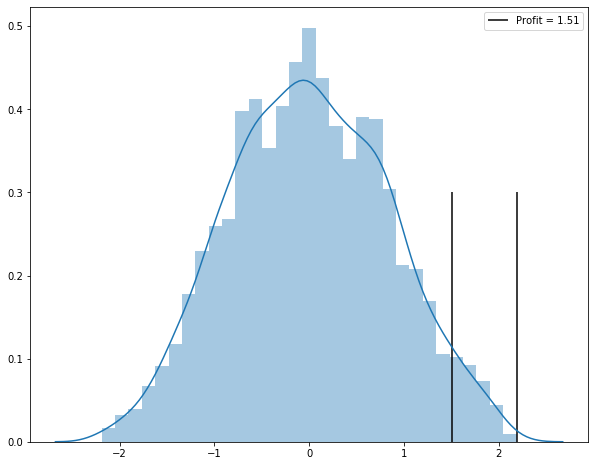

Max profit on validation data = 2.880000000000109
(4, 1, 2) 1.4600000000002638
(4, 1, 3) 1.4600000000002638
(4, 2, 2) 1.4600000000002638
(4, 2, 3) 1.0800000000001546
200
(4, 1, 2)


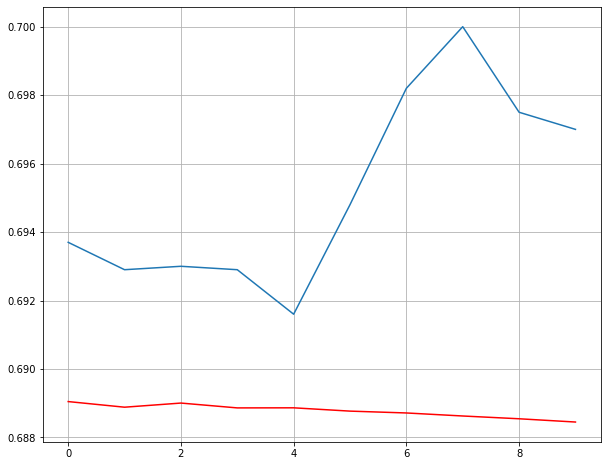

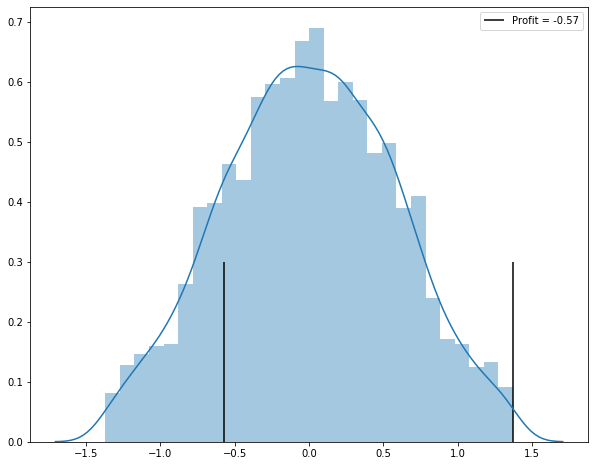

Max profit on validation data = 2.9199999999998454
(4, 1, 2) 0.2799999999999727
(4, 1, 3) 0.0
(4, 2, 2) 0.2799999999999727
(4, 2, 3) -0.4800000000000182
220
(4, 1, 2)


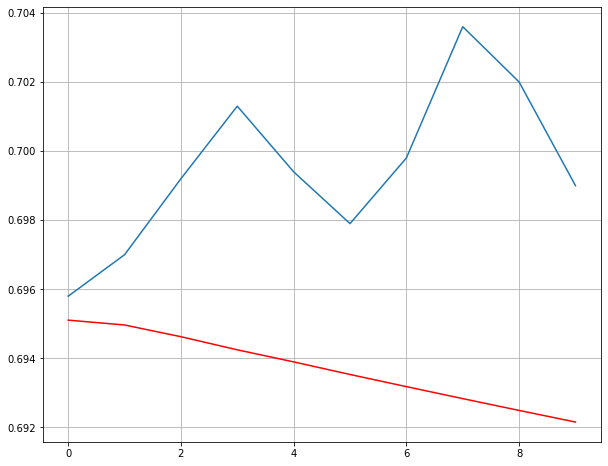

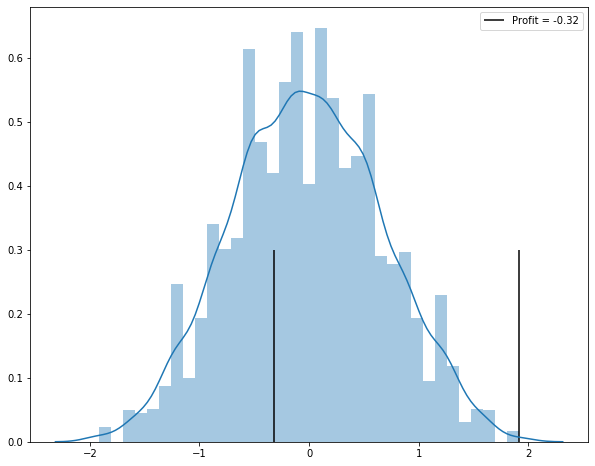

Max profit on validation data = 3.699999999999818
(4, 1, 2) -0.2800000000002001
(4, 2, 2) -0.40000000000009095
(4, 2, 3) -0.40000000000009095
(4, 2, 4) -0.40000000000009095
240
(4, 1, 3)


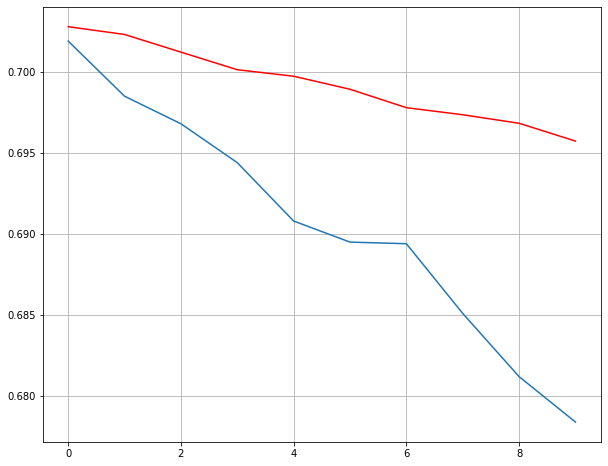

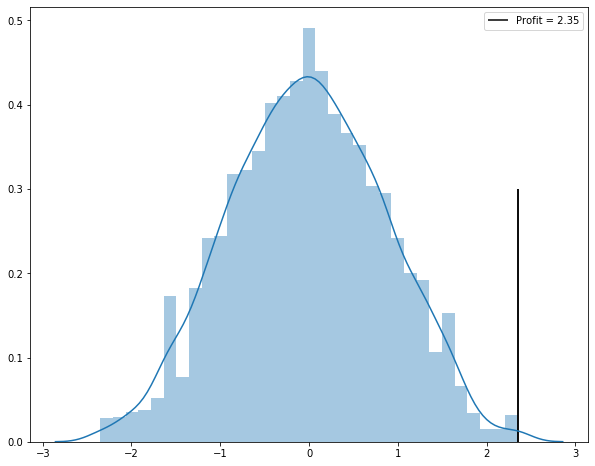

Max profit on validation data = 3.6700000000000728
(4, 1, 2) -0.6900000000000546
(4, 1, 3) 0.41000000000008185
(4, 2, 2) 1.0499999999999545
(4, 2, 3) 1.0499999999999545
(4, 2, 4) 0.2699999999999818
260
(4, 2, 2)


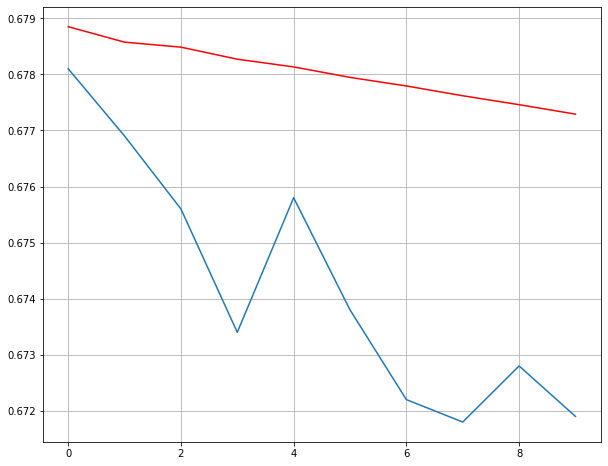

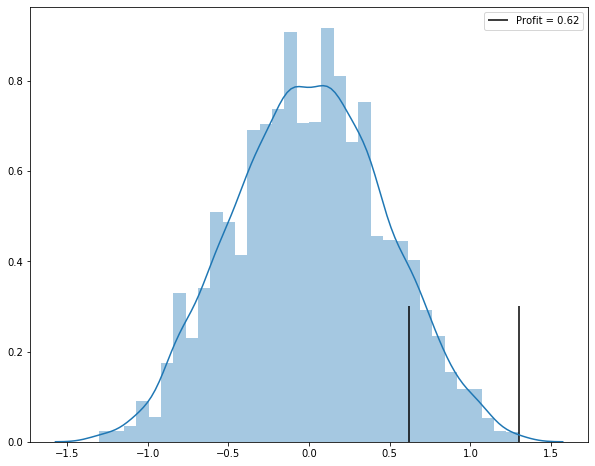

In [237]:
for start in np.arange(0, 280, 20):
    
    p = range(4,5)
    d = range(1,3)
    q = range(2,5)

    # Forecast Horizon
    h = 10

    # Start and end indices for training data
#     start = 0
    end = start + 400

    val_size = 14

    # Split into data and labels 
    train_val = ts[start : end-val_size]
    val = ts[end-val_size : end]

    train = ts[start : end]
    y = ts[end : end+h]

    pdq = list(itertools.product(p,d,q))

    aics = []
    profits = []

    print("Max profit on validation data = {}".format(backtest(val, val)[0]))

    for params in pdq:

        try:
            model = ARIMA(train_val, order=params)
            model_fit = model.fit()

            aics.append(model_fit.aic)

            val_predictions = model_fit.forecast(val_size)[0]
            profit = backtest(val, val_predictions)[0]
            profits.append(profit)
    #         predictions = model_fit.forecast(h)[0]
            print(params, backtest(val, val_predictions)[0])
        except:
            aics.append(5000)
            profits.append(0)

    max_profit_idx = np.argmax(profits)
    invert = True if profits[max_profit_idx] > 2 else (True if profits[max_profit_idx] < -2 else False)
    best_model_params = pdq[max_profit_idx]

    model = ARIMA(train, order=best_model_params)
    model_fit = model.fit()
    predictions = model_fit.forecast(h)[0]

    print(start)
    print(best_model_params)
#     print("Invert =", invert)
    model_profit, equity = backtest(y, predictions, invert=False)

    plt.plot(y.values)
    plt.plot(predictions, color='r')
    plt.grid()
    plt.show()

    random_simulation(y, model_profit)



Max profit on validation data = 1.2099999999999227
(0, 1, 0) 0.6299999999999955
(0, 1, 1) 0.6299999999999955
(0, 1, 2) 0.6299999999999955
(0, 1, 3) 0.6899999999999409
(0, 1, 4) 0.6899999999999409
(0, 2, 0) 0.6299999999999955
(0, 2, 1) -0.6299999999999955
(1, 1, 0) 0.6299999999999955
(1, 1, 1) 0.6299999999999955
(1, 2, 0) -0.6299999999999955
(1, 2, 1) -0.6299999999999955
(1, 2, 2) -0.6299999999999955
(1, 2, 3) -0.6299999999999955
(1, 2, 4) -0.6299999999999955
(2, 1, 0) 0.6299999999999955
(2, 1, 1) 0.6899999999999409
(2, 1, 2) -0.3100000000000591
(2, 2, 0) -0.6299999999999955
(2, 2, 1) -0.6299999999999955
(2, 2, 2) -0.6299999999999955
(2, 2, 3) -0.6299999999999955
(2, 2, 4) -0.6299999999999955
(3, 1, 0) 0.6899999999999409
(3, 1, 1) 0.6899999999999409
(3, 1, 2) 0.6899999999999409
(3, 1, 3) 0.8500000000000227
(3, 1, 4) -0.11000000000001364
(3, 2, 0) -0.6299999999999955
(3, 2, 1) -0.6299999999999955
(3, 2, 2) -0.6299999999999955
(3, 2, 3) -0.6299999999999955
(3, 2, 4) -0.6299999999999955
(4

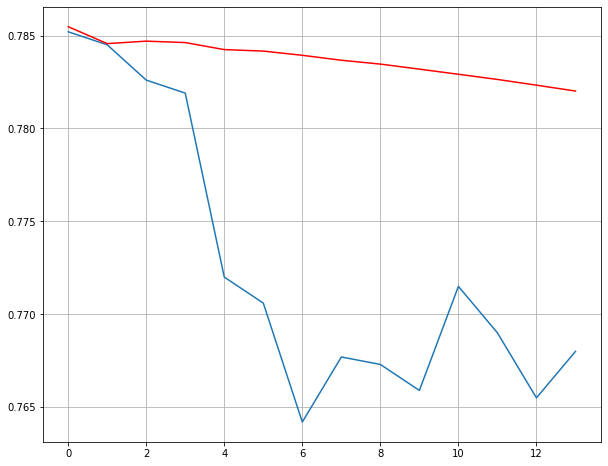

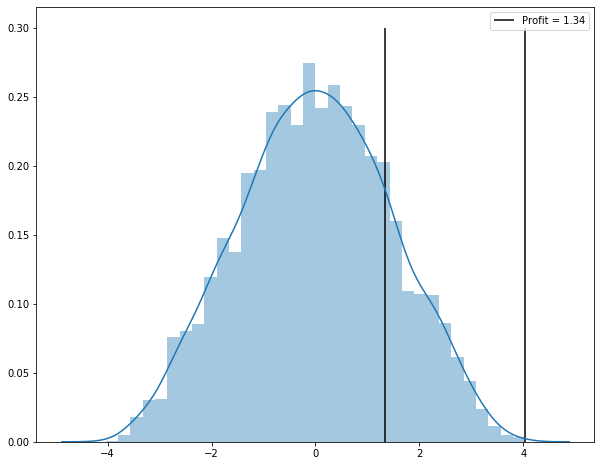

In [239]:
p = range(0,5)
d = range(1,3)
q = range(0,5)

# Forecast Horizon
h = 14

# Start and end indices for training data
start = 0
end = start + 200

val_size = 7

# Split into data and labels 
train_val = ts[start : end-val_size]
val = ts[end-val_size : end]

train = ts[start : end]
y = ts[end : end+h]

pdq = list(itertools.product(p,d,q))

aics = []
profits = []

print("Max profit on validation data = {}".format(backtest(val, val)[0]))

for params in pdq:
    
    try:
        model = ARIMA(train_val, order=params)
        model_fit = model.fit()
        
        aics.append(model_fit.aic)
        
        val_predictions = model_fit.forecast(val_size)[0]
        profit = backtest(val, val_predictions)[0]
        profits.append(profit)
#         predictions = model_fit.forecast(h)[0]
        print(params, backtest(val, val_predictions)[0])
    except:
        aics.append(5000)
    
max_profit_idx = np.argmax(np.abs(profits))
invert = True if profits[max_profit_idx] < 0 else False
best_model_params = pdq[max_profit_idx]

model = ARIMA(train, order=best_model_params)
model_fit = model.fit()
predictions = model_fit.forecast(h)[0]

print(start)
print(best_model_params)
model_profit, equity = backtest(y, predictions, invert=invert)

plt.plot(y.values)
plt.plot(predictions, color='r')
plt.grid()
plt.show()

random_simulation(y, model_profit)



0
(2, 1, 2)


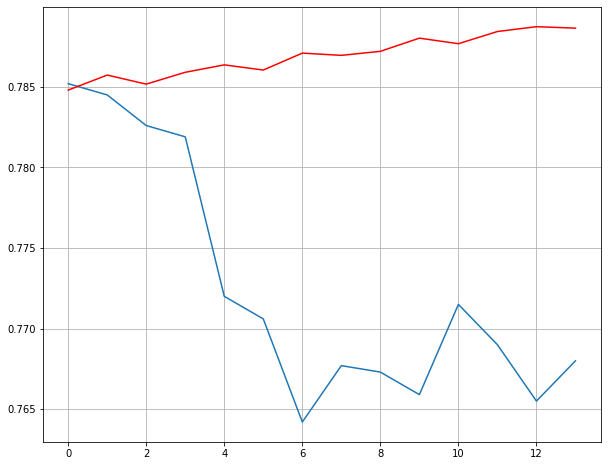

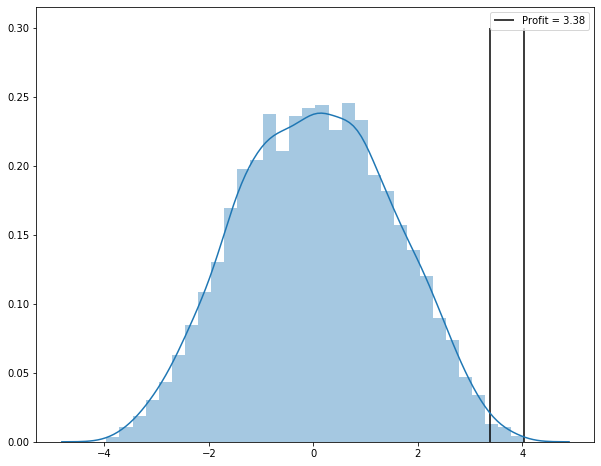

In [149]:
model = ARIMA(train, order=(3,1,4))
model_fit = model.fit()
predictions = model_fit.forecast(h)[0]

print(start)
print(best_model_params)
model_profit, equity = backtest(y, predictions, invert=True)

plt.plot(y.values)
plt.plot(predictions, color='r')
plt.grid()
plt.show()

random_simulation(y, model_profit)

In [132]:
list(zip(pdq, aics))[np.argmin(aics)]

((2, 1, 2), -1628.639700609373)

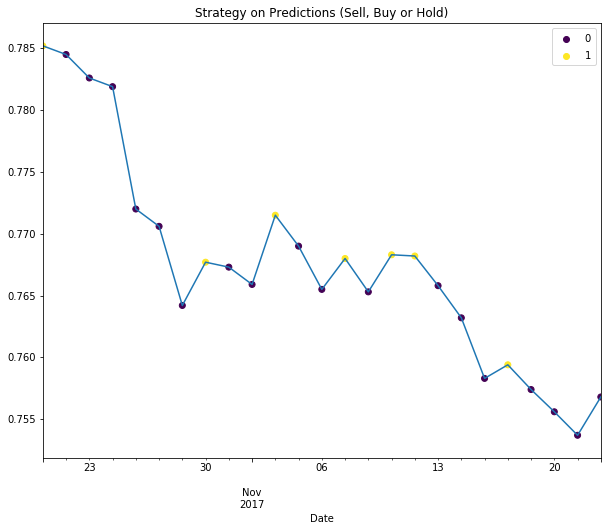

-1812.3471763249668

In [119]:
# plt.plot(y.index, y)
# plt.plot(y.index, predictions, color='red')
# plt.show()

_ = buy_sell_plot(y, predictions)
model_fit.aic

In [114]:
# Forecast Horizon
h = 25

# Start and end indices for training data
start = 0
end = start + 200

# Split into data and labels 
train = ts[start:end]
y = ts[end: end+h]

# Create ARIMA model
# model = ARIMA(train, (4,1,4))
# model_fit = model.fit()
history = [x for x in train]
predictions = []

for t in range(len(y)):
    model = ARIMA(history, order=(2,2,2))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = y[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
    


predicted=0.784625, expected=0.785200
predicted=0.785044, expected=0.784500
predicted=0.784373, expected=0.782600
predicted=0.782669, expected=0.781900
predicted=0.781731, expected=0.772000
predicted=0.772828, expected=0.770600
predicted=0.769870, expected=0.764200
predicted=0.764155, expected=0.767700
predicted=0.766345, expected=0.767300
predicted=0.766067, expected=0.765900
predicted=0.765589, expected=0.771500
predicted=0.769777, expected=0.769000
predicted=0.769210, expected=0.765500
predicted=0.765358, expected=0.768000
predicted=0.767036, expected=0.765300
predicted=0.764627, expected=0.768300
predicted=0.767347, expected=0.768200
predicted=0.767914, expected=0.765800
predicted=0.765443, expected=0.763200
predicted=0.762541, expected=0.758300
predicted=0.757889, expected=0.759400
predicted=0.758354, expected=0.757400
predicted=0.756499, expected=0.755600
predicted=0.755059, expected=0.753700
predicted=0.752689, expected=0.756800


In [121]:
for start in np.arange(0, 600, 100):

    # Forecast Horizon
    h = 14

    # Start and end indices for training data
    end = start + 200

    # Split into data and labels 
    train = ts[start:end]
    y = ts[end: end+h]
    
    try:
        # Create ARIMA model
        model = ARIMA(train, (4,1,4))
        model_fit = model.fit()
    except:
        # Create ARIMA model
        model = ARIMA(train, (4,1,2))
        model_fit = model.fit()
    
    print(model_fit.aic)
    predictions = model_fit.forecast(h)[0]

#     model_profit, equity = backtest(y, predictions)
#     plt.plot(y.values)
#     plt.plot(predictions, color='r')
#     plt.grid()
#     plt.show()

#     random_simulation(y, model_profit)
    

-1621.471103168013
-1617.4104709957464
-1636.6400941363127
-1631.6238662051146
-1641.0649882028697
-1707.2444199282686


0 ____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________


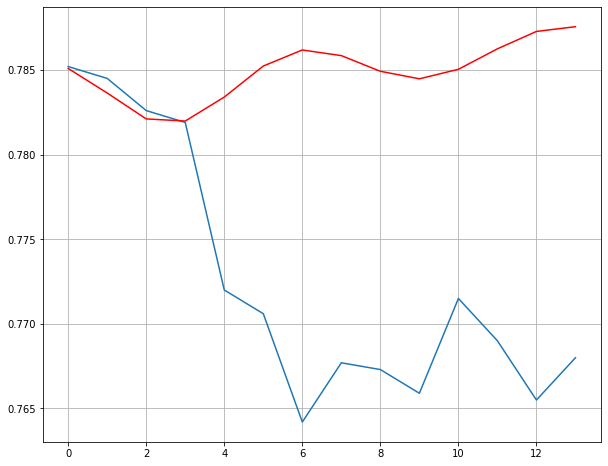

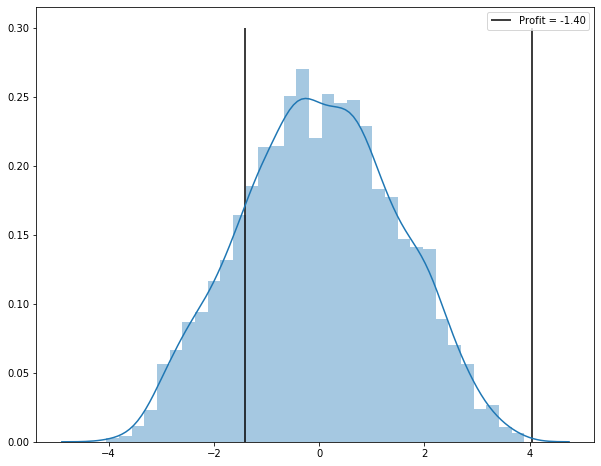

____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
100 ____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________


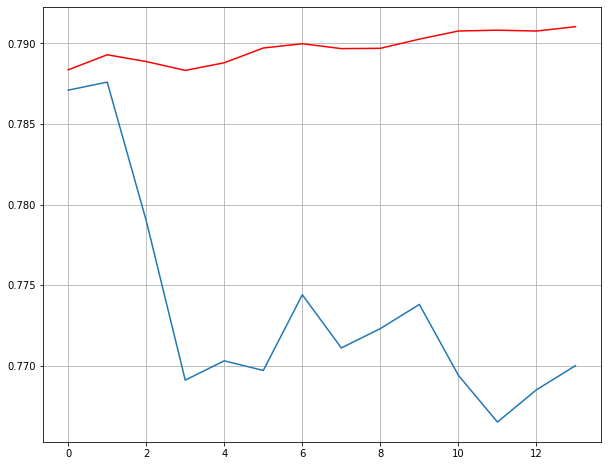

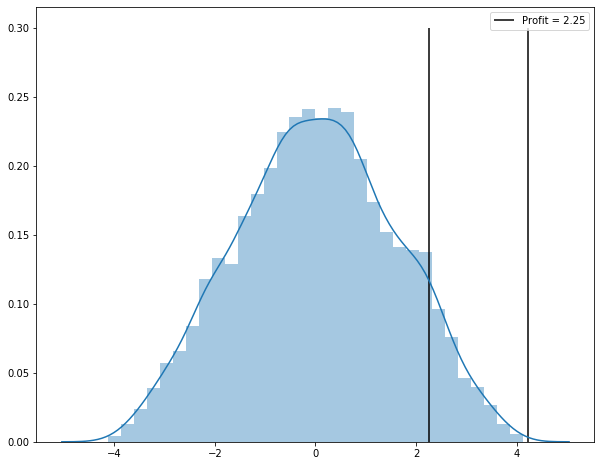

____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
200 ____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________


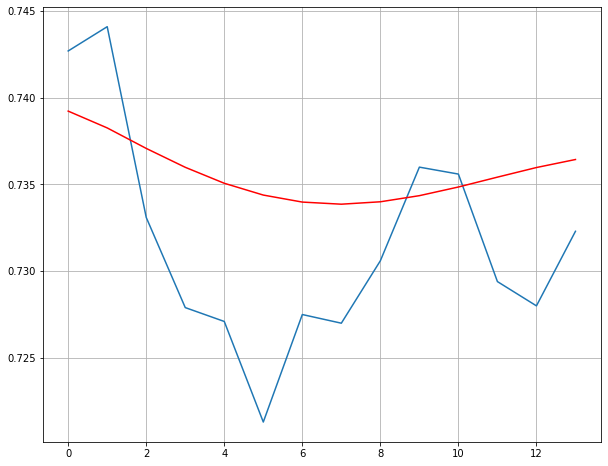

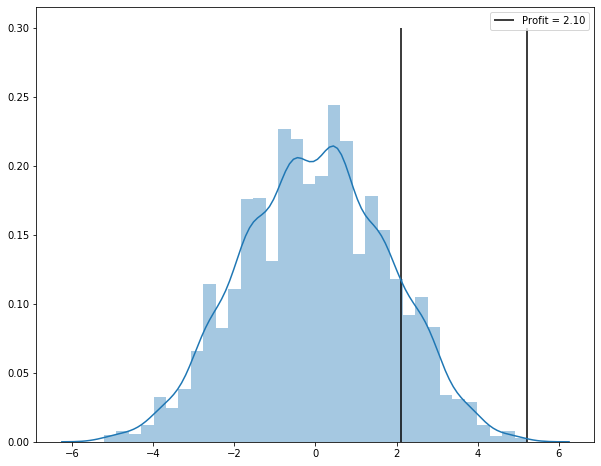

____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
300 ____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________


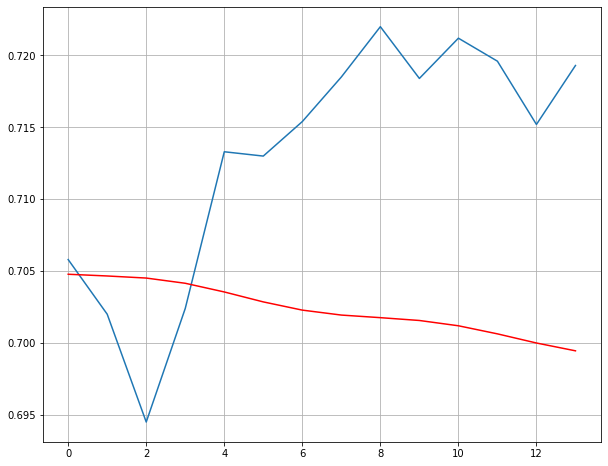

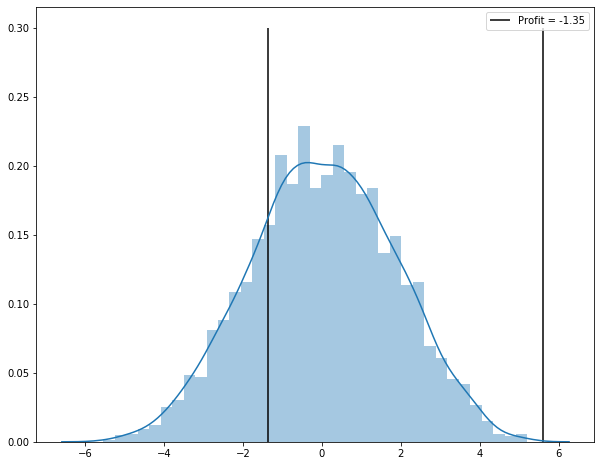

____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
400 ____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________


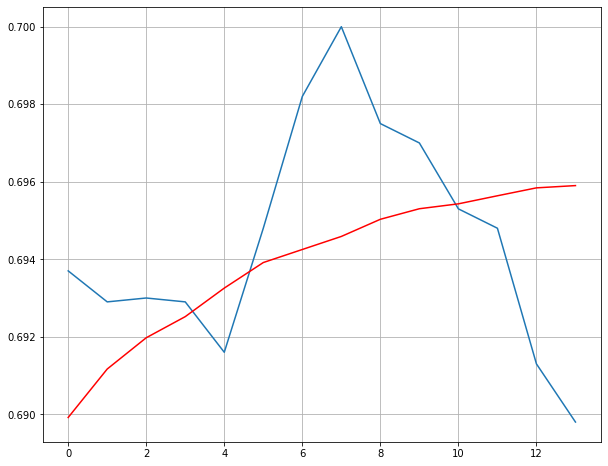

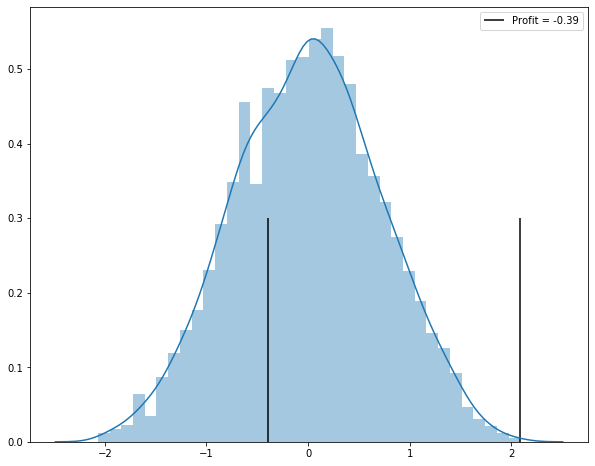

____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
500 ____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________


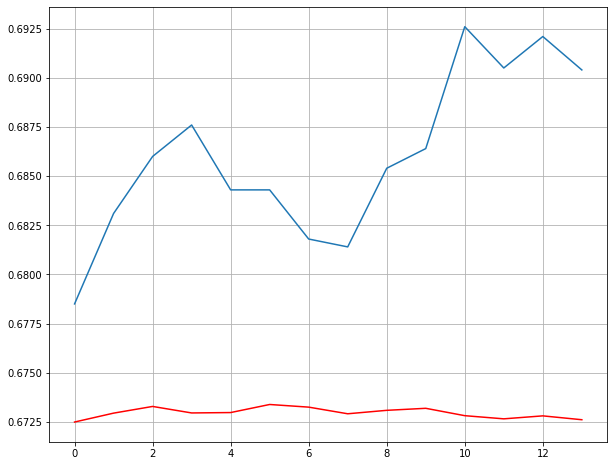

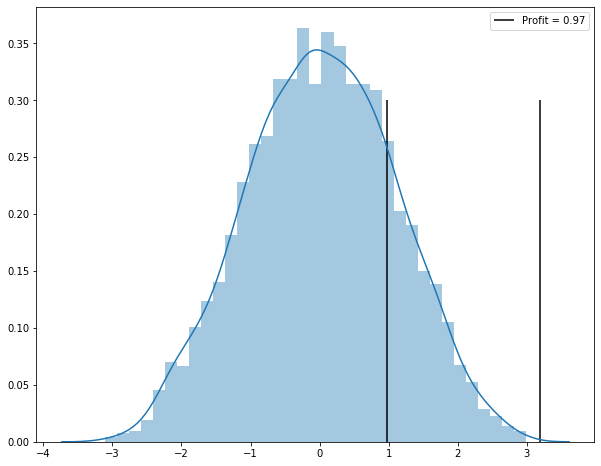

____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________


In [140]:
for start in np.arange(0, 600, 100):
    
    p = range(2,5)
    d = range(1,3)
    q = range(2,5)

    # Forecast Horizon
    h = 14

    # Start and end indices for training data
    end = start + 200

    # Split into data and labels 
    train = ts[start:end]
    y = ts[end: end+h]

    pdq = list(itertools.product(p,d,q))

    aics = []

    for params in pdq:

        try:
            model = ARIMA(train, order=params)
            model_fit = model.fit()
            aics.append(model_fit.aic)
        except:
            aics.append(5000)

    min_aic_idx = np.argmin(aics)
    best_model_params = list(zip(pdq, aics))[min_aic_idx][0]

    # Create ARIMA model
    model = ARIMA(train, order=best_model_params)
    model_fit = model.fit()

    predictions = model_fit.forecast(h)[0]

    print(start, "_"*300)
    model_profit, equity = backtest(y, predictions)

    plt.plot(y.values)
    plt.plot(predictions, color='r')
    plt.grid()
    plt.show()

    random_simulation(y, model_profit)
    
    print("_"*300)
